In [1]:
import math
from copy import deepcopy
import random
import chess
from ChessWrapper import ChessWrapper
from evaluation import *
import time
import signal
import chess.pgn
import pandas as pd
from stockfish import Stockfish
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the regression-based static evaluation model
lr_eval = pickle.load(open('lr_eval.pkl', 'rb'))

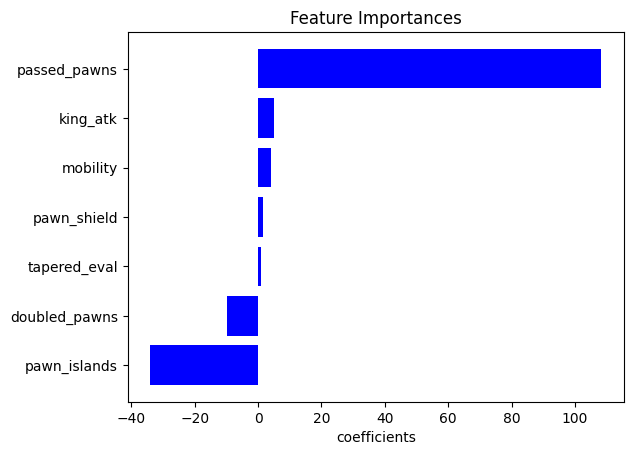

-33.9933362519611 pawn_islands
-9.669483184185557 doubled_pawns
0.8223653557110284 tapered_eval
1.4605176138458864 pawn_shield
4.237300439826688 mobility
4.9471494240554605 king_atk
108.25428540858158 passed_pawns


In [4]:
importances = lr_eval.coef_
indices = np.argsort(importances)

features = ['tapered_eval', 'king_atk', 'mobility', 'pawn_shield', 'pawn_islands','doubled_pawns', 'passed_pawns']


plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('coefficients')
plt.show()

for i in indices:
    print(importances[i], features[i])

In [5]:
def reg_eval(board):
    """
    Return a static evaluation of the board using the lr_eval model.
    """
    feat = create_features(board)
    return lr_eval.predict(feat)[0]

In [6]:
class Node:
    """MCTS Tree Node Object, which represents nodes in the chess search tree."""
    
    def __init__(self, move, parent, explore=math.sqrt(2)):
        """Constructor function to initialize a node."""
        self.move = move # move that we played from the parent state to get to this state
        self.parent = parent # parent Node
        
        self.Q = 0 # number of wins
        self.N = 0 # number of rollouts
        self.children = {} # children nodes
        self.explore = explore # exploration factor
    
    # explore = exploration factor in the Upper Confidence bound applied to Trees (UCT)
    def value(self):
        """Return the UCT value of this node"""
        if self.N == 0:
            # if for some reason we do not want any exploration
            if self.explore == 0: 
                return 0
            # in selection phase, we ensure that MCTS at least gives each child node a chance
            return float('inf') 
        
        # filler value, in practice .value() is never used for the root node
        if self.parent is None: 
            return self.Q / self.N 
        
        # UCT Formula to evaluate the goodness of a node
        return self.Q / self.N + self.explore * math.sqrt(math.log(self.parent.N) / self.N)
    
    def add_children(self, children):
        """
        Add children to the current node. self.children is a dictionary mapping move to resulting child.
        
        children: input value, list of Node objects.
        """
        for child in children:
            self.children[child.move] = child

    def __str__(self):
        """Represent diagnostic information about this Node."""
        return "move: {move}, Q: {Q}, N: {N}, value: {V}".format(move=str(self.move), Q=self.Q, N=self.N, V=self.value())

In [7]:
class MCTS:
    
    def __init__(self, state, max_depth, explore=math.sqrt(2), eval_func=tapered_eval):
        """Constructor function to initalize the MCTS Tree."""
        
        self.explore = explore # exploration factor
        self.root_node = Node(None, None, explore=self.explore) # Root node starts as a dummy node
        self.root_state = deepcopy(state) # Root state starts as a dummy state
        self.max_depth = max_depth # Max depth to be used for rollouts
        self.eval_func = eval_func

        # statistics
        self.total_rollouts = 0 # Total number of rollouts performed
        self.total_time = 0 # Total amount of time spent searching
        self.total_depth = 0 # Total depth used for rollouts
    
    def select(self):
        """
        Selection Stage of MCTS. 
        Start from the root node, and greedily traverse down the tree by finding best UCT child.
        Return when a leaf node is found.
        """
        
        curr_node = self.root_node
        curr_state = deepcopy(self.root_state)
        
        # continue until we hit a leaf
        while len(curr_node.children) != 0:
            children = curr_node.children.values()
            
            # find the max value, and then find the node candidates who have max value
            max_val = float('-inf')
            for child in children:
                max_val = max(max_val, child.value())
                
            # In (unlikely but possible) case of ties 
            max_val_children = [] 
            for child in children:
                if abs(child.value() - max_val) <= 0.001: # account for float imprecisions
                    max_val_children.append(child)

            if len(max_val_children) == 0:
                max_val_children = list(children)

            # In case of multiple max value children, just return one arbitrarily
            curr_node = random.choice(max_val_children)
            
            curr_state.push(curr_node.move) 
            
            # unexplored, has never done a rollout
            if curr_node.N == 0: 
                return curr_node, curr_state
        
        return curr_node, curr_state
        
    
    def expand(self, leaf_node, leaf_state, use_sf=False):
        """
        Expansion Stage of MCTS.
        After selecting, try to add all of the possible children (using legal moves)
        Given a leaf node and its associated state, return an expanded node and its associated state.
        """
        if leaf_state.is_game_over():
            return None, None
        
        next_legal_moves = leaf_state.get_legal_moves()
                
        children = [] # add the children to the leaf node
        for next_move in next_legal_moves:
            children.append(Node(next_move, leaf_node, explore=self.explore))        
        
        leaf_node.add_children(children)
        node = random.choice(children) # pick random child to simulate
        leaf_state.push(node.move)
        
        return node, leaf_state
    
    def rollout_policy(self, state):
        """
        Use a policy to choose next moves in the rollout. By default, return a move at uniform random.
        """
        return random.choice(state.get_legal_moves())
    
    # if limit_depth=True, then we artificially terminate the rollout and do an evaluation
    def rollout(self, state):
        """
        Rollout Stage of MCTS.
        Run Rollout up to specified depth, and return (predicted winner, static evaluation) at the end of the rollout.
        """
        
        depth = 0
        state_copy = deepcopy(state) # deepcopy the state to not change the original
        
        while depth < self.max_depth and not state_copy.is_game_over():
            state_copy.push(self.rollout_policy(state_copy))
            depth += 1
            
        self.total_rollouts += 1
        self.total_depth += depth
        
        static_eval = self.eval_func(state_copy)
        
        if static_eval > 0:
            return (chess.WHITE, static_eval/100.0)
        elif static_eval < 0:
            return (chess.BLACK, static_eval/100.0)
        else:
            return (None, 0)

    def backprop(self, node, turn, outcome):
        """
        Backpropagation Stage of MCTS.
        Update the tree given the results of the Rollout.
        """
        
        winner, static_eval = outcome
        reward = -abs(static_eval) if winner == turn else abs(static_eval)
        
        if winner is None:
            reward = 0
        
        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            
            if winner is None:
                reward = 0
            else:
                reward = -reward

    def search(self, time_limit, operation_limit=float('inf')):
        """
        Combine the 4 stages to create the search tree under either a time or operation limit.
        """
        
        def handle_timeout(signum, frame):
            raise TimeoutError
        signal.signal(signal.SIGALRM, handle_timeout)
        signal.alarm(time_limit) # when the limit limit is reached, break out
        
        try:
            operations = 0
            while True and operations < operation_limit:
                leaf_node, leaf_state = self.select()
                node, state = self.expand(leaf_node, leaf_state)

                if node is None or state is None: # the game is terminated
                    node, state = leaf_node, leaf_state
                
                outcome = self.rollout(state)
                self.backprop(node, state.get_turn(), outcome)
                operations += 1
            
        except TimeoutError:
            self.total_time += time_limit
            
        finally:
            signal.alarm(0)

    def print_statistics(self):
        """
        Print diagnostic information about MCTS search.
        """
        print("rollouts/sec: {rps}, depth/rollout: {dpr}".format(rps=self.total_rollouts/self.total_time, dpr=self.total_depth/self.total_rollouts))
        
    def move(self, move):
        """
        Push a new move.
        """
        if move in self.root_node.children:
            self.root_state.push(move) # move forward in the MCTS
            self.root_node = self.root_node.children[move]
            return
        else:
            self.root_state.push(move)
            self.root_node = Node(None, None, explore=self.explore)
    
    def find_best_move(self):
        """
        Find the best next move.
        Choose the action leading to the state with the highest N (most explored node, therefore most likely to be useful)
        """
        
        if self.root_state.is_game_over():
            raise Exception("Cannot find best move, game has already terminated")
        
        children = self.root_node.children.values()
            
        # find the max value, and then find the node candidates who have max value
        max_N = -1
        for child in children:
            max_N = max(max_N, child.N)
        
        max_N_children = []

        for child in children:
            if child.N == max_N:
                max_N_children.append(child)

        return random.choice(max_N_children).move

In [8]:
def play_chess(time_limit, max_depth=10, explore=math.sqrt(2)):
    state = ChessWrapper()
    mcts = MCTS(state, max_depth, explore=explore)

    while not state.is_game_over():
        print("Current tapered evaluation:")
        print(tapered_eval(state))
        
        print("Current state:")
        print(state)
        

        input_move = input('What is the next move? \n')
        user_move = state.parse_san(input_move)
        
        while user_move not in state.get_legal_moves():
            print("Cannot make illegal move")
            
            input_move = input('What is the next move? \n')
            user_move = state.parse_san(input_move)

        state.push(user_move)
        mcts.move(user_move)

        print(state)

        if state.is_game_over():
            print("Player one wins")
            break

        print("Searching for best move")

        mcts.search(time_limit)
        move = mcts.find_best_move()

        print("MCTS's best move: ", state.san(move))

        state.push(move)
        mcts.move(move)
        mcts.print_statistics()

        if state.is_game_over():
            print("Player two wins")
            break

In [9]:
def vs_sf(elo=1600, max_depth = 0, time_limit=5, explore=math.sqrt(2), wtm=True, fen=None, eval_func=tapered_eval):
    
    """
    Run 1 game against ELO-Adjusted Stockfish.

    elo: ELO setting for Stockfish.
    max_depth: max_depth setting for MCTS.
    time_limit: max time per search for MCTS.
    explore: exploration factor for MCTS.
    wtm: True indicates MCTS moves first and plays White. False indicates MCTS moves second and plays Black.
    fen: FEN string to input custom starting position.
    """
    
    if fen is None:
        b = ChessWrapper()

        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_elo_rating(elo)
        
        mcts = MCTS(b, max_depth=max_depth, explore=explore, eval_func=eval_func)
    else:
        b = ChessWrapper(fen)
        
        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_fen_position(fen)
        sf.set_elo_rating(elo)
        
        mcts = MCTS(b, max_depth=max_depth, explore=explore)
    
    game = chess.pgn.Game() # to save the game if desired
    game.headers["Event"] = "sf elo: " + str(elo) + ', max_depth: ' + str(max_depth) + ', time_limit: ' + str(time_limit) + ', explore: ' + str(explore)
    
    if fen is not None:
        game.setup(fen)
        
    node = None

    while True:
        if b.is_game_over():
            break
        if wtm:
            mcts.search(time_limit)
            m = mcts.find_best_move()
        else:
            m = chess.Move.from_uci(sf.get_best_move())

        b.push(m)
        mcts.move(m)
        sf.make_moves_from_current_position([str(m)])
        
        if node is None:
            node = game.add_variation(m)
        else:
            node = node.add_variation(m)
        
        if wtm:
            print('mcts move')
        else:
            print('sf move')

        print(b)
        print('-' * 15)
        wtm = not wtm
    return b.outcome(), game

In [10]:
def est_elo(max_depth=0, time_limit=5, explore=math.sqrt(2), eval_func=tapered_eval):
    """
    Return an ELO estimate of MCTS by playing small tournament against Stockfish.
    Play against X-ELO stockfish, and if MCTS scores 3.0+/6.0, increment X and play again. Repeat until MCTS can no longer beat Stockfish.
    """
    
    # sicilian (open), queen's indian, reti transposed to english
    openings = [
        'rnbqkb1r/pp2pppp/3p1n2/8/3NP3/8/PPP2PPP/RNBQKB1R w KQkq - 1 5',
        'rn1qkb1r/p1pp1ppp/bp2pn2/8/2PP4/5NP1/PP2PP1P/RNBQKB1R w KQkq - 1 5',
        'rnbqk2r/ppp1ppbp/3p1np1/8/2P1P3/2N2N2/PP1P1PPP/R1BQKB1R w KQkq - 0 5'
    ]
    
    random.shuffle(openings)
    
    lo = 100
    
    df = pd.DataFrame(columns = ['max_depth', 'time_limit', 'explore', 'elo', 'outcome', 'game'])
    
    while True:
        mcts_score = 0
        sf_score = 0
        
        # play 3 pairs
        for i in range(3):
            
            print('-' * 15)
            print(max_depth, time_limit, explore, lo)
            # alpha beta plays white
            mcts_white_oc, mcts_white_game = vs_sf(elo=lo, max_depth=max_depth, time_limit=time_limit, explore=explore, wtm=True, fen=openings[i], eval_func=eval_func)
            
            if mcts_white_oc.winner == chess.WHITE:
                mcts_score += 1
            elif mcts_white_oc.winner == chess.BLACK:
                sf_score += 1
            else:
                mcts_score += 0.5
                sf_score += 0.5
                
            new_row = {'max_depth': max_depth, 'time_limit': time_limit, 'explore': explore, 'elo': lo, 'outcome': mcts_white_oc.winner != chess.BLACK, 'game': mcts_white_game}
            df = df._append(new_row, ignore_index=True)
            print(mcts_white_oc)
            
            # if either player cuts off early, don't need to play the rest
            if mcts_score >= 3 or sf_score >= 3.5:
                break
                
            print('-' * 15)
            print(max_depth, time_limit, explore, lo)
                
            # alpha beta plays black
            mcts_black_oc, mcts_black_game = vs_sf(elo=lo, max_depth=max_depth, time_limit=time_limit, explore=explore, wtm=False, fen=openings[i], eval_func=eval_func)
            
            if mcts_black_oc.winner == chess.BLACK:
                mcts_score += 1
            elif mcts_black_oc.winner == chess.WHITE:
                sf_score += 1
            else:
                mcts_score += 0.5
                sf_score += 0.5
            new_row = {'max_depth': max_depth, 'time_limit': time_limit, 'explore': explore, 'elo': lo, 'outcome': mcts_black_oc.winner != chess.WHITE, 'game': mcts_black_game}

            df = df._append(new_row, ignore_index=True)
            print(mcts_black_oc)
            
            # if either player cuts off early, don't need to play the rest
            if mcts_score >= 3 or sf_score >= 3.5:
                break
                
        if mcts_score >= 3:
            lo += 100
        else:
            break
    return df, lo

In [11]:
puzzles = pickle.load(open('m2_puzzles.pkl', 'rb'))

In [12]:
random.shuffle(puzzles)

In [13]:
sample = puzzles[:20]

In [14]:
def test_tactics(puzzles, time_limit, explore):
    counter = 0
    for FEN, solution in puzzles:
        b = ChessWrapper(FEN)
        mcts = MCTS(b, max_depth=0, explore=explore, eval_func=tapered_eval)
    
        correct = True
        mcts_to_move = True
        for i in range(3):
            if mcts_to_move:
                mcts.search(time_limit)
                m = mcts.find_best_move()
                
                if str(m) != solution[i]:
                    correct = False
                    break
                    
                b.push(m)
                mcts.move(m)
            else:
                m = b.parse_uci(solution[i])
                b.push(m)
                mcts.move(m)
            mcts_to_move = not mcts_to_move
        if correct:
            counter += 1
    return counter

In [15]:
tactics_results = []
for explore in range(1, 11):
    num_correct = test_tactics(sample, 60, explore)
    tactics_results.append(num_correct)

KeyboardInterrupt: 

In [ ]:
print(tactics_results)

In [ ]:
# Estimate the ELO using tapered eval
df_results = pd.DataFrame(columns = ['max_depth', 'time_limit', 'explore', 'elo'])
df_games = pd.DataFrame(columns = ['max_depth', 'time_limit', 'explore', 'elo', 'outcome', 'game'])

for d in range(1, 11):
    df, elo = est_elo(max_depth=0, time_limit=60, explore=d, eval_func=tapered_eval)
    new_row = {'max_depth': 0, 'time_limit': 60, 'explore': d, 'elo': elo}
    df_results = df_results._append(new_row, ignore_index=True)
    df_games = pd.concat([df_games, df])
    print(df_results)
    print(df_games)

In [ ]:
# Estimate the ELO using regression eval
df_results2 = pd.DataFrame(columns = ['max_depth', 'time_limit', 'explore', 'elo'])
df_games2 = pd.DataFrame(columns = ['max_depth', 'time_limit', 'explore', 'elo', 'outcome', 'game'])

for d in range(1, 11):
    df, elo = est_elo(max_depth=0, time_limit=60, explore=d, eval_func=reg_eval)
    new_row = {'max_depth': 0, 'time_limit': 60, 'explore': d, 'elo': elo}
    df_results2 = df_results2._append(new_row, ignore_index=True)
    df_games2 = pd.concat([df_games2, df])
    print(df_results2)
    print(df_games2)